<a href="https://colab.research.google.com/github/Datangels/Machine_Learning_with_PySpark/blob/master/pyspark_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Google Colab configuration & creation the SparkSession Object**

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

## **Read the Dataset**

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset_not_clean = spark.read.csv('/content/drive/My Drive/pycharm_colab_training/dataset/flowers.csv',inferSchema=True, header=True)

## **Exploratory Data Analysis**


In [0]:
# print((dataset_not_clean.count(), len(dataset_not_clean.columns)))
dataset_not_clean.printSchema()
# dataset_not_clean.describe().show()
# print((dataset_not_clean.count(), len(dataset_not_clean.columns)))

## **Feature Engineering**

In [0]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [0]:
input_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
vec_assembler = VectorAssembler(inputCols = input_cols,outputCol='features')
final_data = vec_assembler.transform(dataset_not_clean)
final_data.show(10)

## **Build K-Means Clustering Model**

In [0]:
from pyspark.ml.clustering import KMeans
errors = []
for k in range(2,10):
  kmeans = KMeans(featuresCol='features',k=k)
  model = kmeans.fit(final_data)
  intra_distance = model.computeCost(final_data)
  errors.append(intra_distance)
print(errors)

[152.36870647734008, 78.94506582597637, 57.473273265494285, 51.260016121427356, 43.49400086206961, 34.42194766505675, 36.48557424242412, 28.606149144736037]


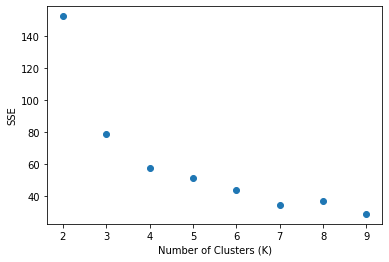

In [0]:
# Plot the intracluster distance with the number of clusters
cluster_number = range(2,10)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number,errors)
plt.show()

In [0]:
# k=3 seems to be the best number of clusters as we can see a sort of elbow formation between three and four values
kmeans = KMeans(featuresCol='features',k=3)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   61|
|         0|   39|
+----------+-----+



In [0]:
predictions = model.transform(final_data)
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   14|
| virginica|         0|   36|
|versicolor|         0|    3|
|    setosa|         1|   50|
|versicolor|         2|   47|
+----------+----------+-----+



## **Visualization of Clusters**


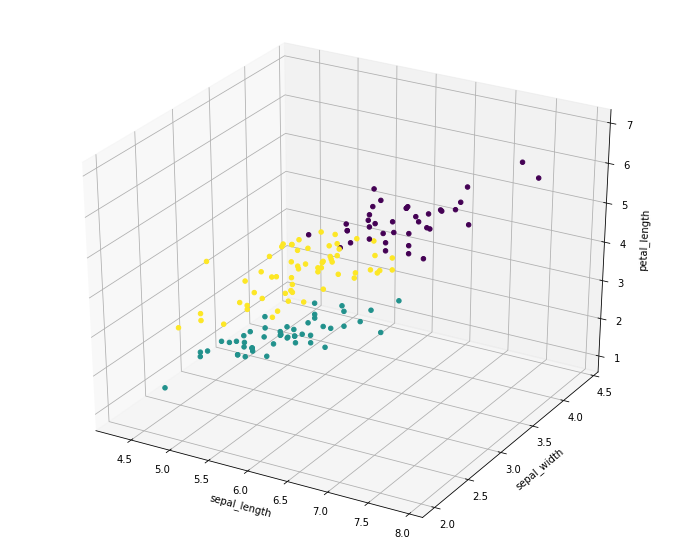

In [0]:
from mpl_toolkits.mplot3d import Axes3D

pandas_df = predictions.toPandas()
cluster_vis = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)

cluster_vis.set_xlabel('sepal_length')
cluster_vis.set_ylabel('sepal_width')
cluster_vis.set_zlabel('petal_length')

plt.show()